# Primerjava algoritmov s Facebook grafom

In [81]:
#import libraries
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
import pandas as pd
import itertools

## Algoritem za Katzovo središčnost

In [82]:
def katz(G, max_num_of_steps, tolerance, alpha, beta, vector=None):
    '''Computes the Katz centrality for the nodes of the graph G.'''
    start = timer()
    A = nx.adjacency_matrix(G)
    diff = 1000
    k = 0
    ones = np.ones((A.shape[1], 1))
    if vector is None:
        vector = ones
    r = beta * vector
    while diff > tolerance and k < max_num_of_steps:
        # inner product of matrix A and vector r
        r, q = alpha*A.dot(r) + beta * ones, r
        diff = np.linalg.norm(q-r, ord=1)
        k += 1
    r = r/np.linalg.norm(r,ord = 2)
    print('process finished after {} iterations'.format(k))
    end = timer()
    # timing of the process
    print('time consumption: {} seconds'.format(end-start))
    return r

## Algoritem za Googlov PageRank

In [83]:
def Qmatrix(matrix):
    '''for given adjecency matrix of a network returns column stohastic matrix Q,
    some columns may still be zero'''
    sums = np.sum(matrix, axis=0)       #array of sums of columns in matrix
    return np.nan_to_num(matrix/sums)   #divide every column with it's sum, if sum is 0,  
                                        #returns zero column instead of nan

def dvector(matrix):
    '''for given adjecency matrix returns transposed vector d, where d[j] = 1 ; if #(outlinks of j) = 0 
    and d[j] = 0 ; otherwise'''
    Q = Qmatrix(matrix)             #compute matrix Q
    sums = np.sum(matrix, axis=0)   #array of sums of columns in matrix 
    d_bool = (sums == 0)            #booleninan array, True if the sum of a column is equal to 0, false otherwise
    d = d_bool*1                    #convert False to 0 and True to 1
    return d

def evector(n):
    '''returns vector v of ones in size of n''' # n = num of columns in matrix
    return np.ones((n,1))    

def Pmatrix(matrix):
    '''returns column stohastic matrix P without zero columns'''
    n = matrix.shape[1]
    Q = Qmatrix(matrix)
    e = evector(n)
    d = dvector(matrix)
    return Q + 1/n*e.dot(d)

def Amatrix(matrix, alpha):
    '''returns ireducible column stohastic matrix A of given matrix, 
    where 0 <= alpha <= 1'''
    n = matrix.shape[1]
    e = evector(n)
    P = Pmatrix(matrix)
    return alpha*P + (1-alpha)*1/n*e.dot(e.transpose())

def pagerank2(matrix, max_num_of_steps, tolerance, alpha):
    '''returns pagerank vector of adjacency matrix, 0<=alpha<=1'''
    start = timer()
    A = Amatrix(matrix, alpha)           #column stohastic matrix from given matrix
    r = A[:,0]  #first guess for vector r is first column of Q
    diff = 1000
    k = 0
    while diff > tolerance and k < max_num_of_steps:
        r, q = A.dot(r), r              #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
        diff = np.linalg.norm(q-r, ord=1)
        k+=1
    print('process finished after {} iterations'.format(k))
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return r

## Funkcija za primerjavo

In [84]:
def rank(array):
    '''Returns vector with ranked values of array,
    where 0 is the minimum value of array'''
    temp = array.argsort(axis=0)
    ranks = temp.argsort(axis=0)
    return ranks

## Graf FACEBOOK

In [85]:
#citation:@misc{snapnets,
#  author       = {Jure Leskovec and Andrej Krevl},
#  title        = {{SNAP Datasets}: {Stanford} Large Network Dataset Collection},
#  howpublished = {\url{http://snap.stanford.edu/data}},
#  month        = jun,
#  year         = 2014
#}
G_fb = nx.read_edgelist('facebook_combined.txt')

In [86]:
M_fb = nx.adjacency_matrix(G_fb)

In [10]:
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


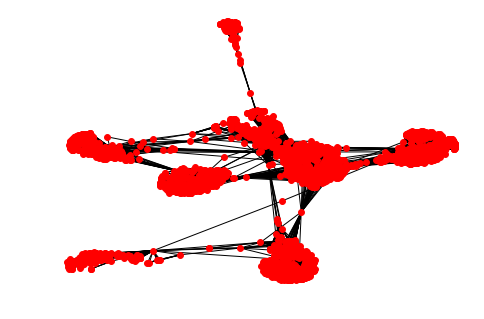

In [12]:
spring_pos = nx.spring_layout(G_fb)
nx.draw(G_fb, pos = spring_pos, node_size = 35)
plt.show()

In [32]:
#max lastna vrednost
print(np.amax(np.linalg.eigvals(M_fb.todense())))
print(1/162.37394233563828)

(162.37394233563828+0j)
0.006158623641304035


## Najini algoritmi

In [117]:
fb_katz = katz(G_fb, 100000, 0.00000000001, 0.003, 1)
fb_katz

process finished after 43 iterations
time consumption: 0.22741099399900122 seconds


array([[0.0270888 ],
       [0.01358663],
       [0.01327439],
       ...,
       [0.01291165],
       [0.01299224],
       [0.01318995]])

In [129]:
fb_pagerank = pagerank2(M_fb, 100000, 0.000000000000000000001, 0.85)
fb_pagerank

process finished after 100000 iterations
time consumption: 983.632749331 seconds


matrix([[0.00622469],
        [0.00023579],
        [0.00019933],
        ...,
        [0.00010579],
        [0.00014798],
        [0.00029451]])

In [ ]:
rank(fb_katz) == rank(fb_pagerank)

Poglejmo v koliko vozliščih se algoritma ujemata.

In [108]:
np.sum(rank(fb_katz) == rank(fb_pagerank))

3

## Vgrajeni algoritmi vs. najini

### Katz

Če želimo enak rezultat kot pri vgrajenem algoritmu moramo pri obeh povečati toleranco na 0.00000000001 = 10 ^(-11).

In [122]:
fb_katz_vgrajen = nx.katz_centrality(G_fb, tol = 0.00000000001, alpha = 0.003, beta = 1)
fb_katz_vgrajen

{'0': 0.027088803500779166,
 '1': 0.01358662505413932,
 '2': 0.013274391796747255,
 '3': 0.013613591485494021,
 '4': 0.013265402288148494,
 '5': 0.01341208558714953,
 '6': 0.013105584330589745,
 '7': 0.013720735411676727,
 '8': 0.013183509143600268,
 '9': 0.015341669753087796,
 '10': 0.013314203720087788,
 '11': 0.012908526449660028,
 '12': 0.012908526449660028,
 '13': 0.014242314033627681,
 '14': 0.013477236138297925,
 '15': 0.012908526449660028,
 '16': 0.013250365974254712,
 '17': 0.013397076709627202,
 '18': 0.012908526449660028,
 '19': 0.013509678119679036,
 '20': 0.013474941449677173,
 '21': 0.015698512389959323,
 '22': 0.0133262628215293,
 '23': 0.013542072283223246,
 '24': 0.013527072841276216,
 '25': 0.01582175604171444,
 '26': 0.015826941628985017,
 '27': 0.013079118855156611,
 '28': 0.01339554931542632,
 '29': 0.01341792645324494,
 '30': 0.013611978617295207,
 '31': 0.013862500335057266,
 '32': 0.01310792539116108,
 '33': 0.012947368555326006,
 '34': 0.013132296893602107,
 '3

In [123]:
katz_seznam_vgrajen = [x for x in fb_katz_vgrajen.values()]
katz_array_vgrajen = np.matrix(katz_seznam_vgrajen).transpose()
katz_array_vgrajen

matrix([[0.0270888 ],
        [0.01358663],
        [0.01327439],
        ...,
        [0.01291165],
        [0.01299224],
        [0.01318995]])

In [124]:
rank(fb_katz) == rank(katz_array_vgrajen)

matrix([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]])

In [125]:
np.sum(rank(fb_katz) == rank(katz_array_vgrajen)), 4039

(4039, 4039)

Naš Katz algoritem deluje! JUHU :)

### PageRank

In [94]:
fb_pagerank_vgrajen = nx.pagerank(G_fb, tol = 0.000000000000000000001, alpha = 0.85, max_iter = 100000)
fb_pagerank_vgrajen

{'0': 0.012769191312925131,
 '1': 0.000213799161463002,
 '2': 0.00016140687504693355,
 '3': 0.00023259820868339021,
 '4': 0.0002622223902921539,
 '5': 0.00027847556520074117,
 '6': 0.000195580482229102,
 '7': 0.000305548604442889,
 '8': 0.00031132695412808693,
 '9': 0.0004938181807428415,
 '10': 7.848907553623661e-05,
 '11': 3.7744384185031684e-05,
 '12': 3.7744384185031684e-05,
 '13': 0.00020998580479082357,
 '14': 0.00023271936218016836,
 '15': 3.7744384185031684e-05,
 '16': 9.907061098850524e-05,
 '17': 0.00019115124280813715,
 '18': 3.7744384185031684e-05,
 '19': 0.0005346558315173752,
 '20': 0.00026763307436548244,
 '21': 0.0005737658981717814,
 '22': 0.00015805772924460106,
 '23': 0.0006833121255685688,
 '24': 0.0001911959362040027,
 '25': 0.000920287105927563,
 '26': 0.0005312291748900394,
 '27': 8.255382177973232e-05,
 '28': 0.00021159182805436736,
 '29': 0.0002335641606249714,
 '30': 0.0001548005262291782,
 '31': 0.00029818261784151116,
 '32': 0.00014683887075537863,
 '33': 0.

In [95]:
pagerank_seznam_vgrajen = [x for x in fb_katz_vgrajen.values()]
pagerank_array_vgrajen = np.matrix(pagerank_seznam_vgrajen).transpose()
pagerank_array_vgrajen

matrix([[0.02710325],
        [0.01359398],
        [0.01328158],
        ...,
        [0.01291865],
        [0.01299928],
        [0.01319709]])

In [96]:
rank(fb_pagerank) == rank(pagerank_array_vgrajen)

matrix([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [128]:
np.sum(rank(fb_pagerank) == rank(pagerank_array_vgrajen)), 4039

(3, 4039)

In [126]:
np.sum(rank(fb_katz) == rank(katz_array_vgrajen)), 4039

(4039, 4039)

In [99]:
np.sum(rank(katz_array_vgrajen) == rank(pagerank_array_vgrajen)), 4039

(4039, 4039)

In [127]:
np.sum(rank(fb_pagerank) == rank(fb_katz)), 4039

(3, 4039)